<br>
# **Word / Doc 2 Vec**


<br>
# **1 Tensorflow 를 활용한 Word2Vec**

<br>
## **1 데이터 전처리**
베를린 선언문

In [1]:
f     = open('./data/베를린선언.txt', 'r')
texts_Berlin_raw = f.read()
f.close()
texts_Berlin = texts_Berlin_raw.split('\n\n')

In [2]:
import string
punct = string.punctuation
punct = [punct[i] for i in range(len(punct))]
punct = punct + ['\n', ')', '(']

for dump in punct: 
    texts_Berlin = [txt.replace(dump, '')    for txt in texts_Berlin]
print(len(texts_Berlin))

309


In [3]:
word_sequence = " ".join(texts_Berlin).split()
word_list     = " ".join(texts_Berlin).split()
word_list     = list(set(word_list))
word_dict     = {w: i for i, w in enumerate(word_list)}

<br>
## **2 Tensorflow  설정**
데이터 및 파라미터설정

In [4]:
import tensorflow as tf
import numpy as np

skip_grams = []
for i in range(1, len(word_sequence) - 1):
    target  = word_dict[word_sequence[i]]
    context = [word_dict[word_sequence[i-1]], word_dict[word_sequence[i+1]]]
    for w in context:
        skip_grams.append([target, w])

In [5]:
# skip-gram 데이터에서 무작위로 데이터를 뽑아 입력값과 출력값의 배치 데이터를 생성
def random_batch(data, size):
    random_inputs, random_labels = [], []
    random_index = np.random.choice(range(len(data)), size, replace=False)
    for i in random_index:
        random_inputs.append(data[i][0])    # target
        random_labels.append([data[i][1]])  # context word
    return random_inputs, random_labels

In [6]:
training_epoch = 300
learning_rate  = 0.1
batch_size     = 20
embedding_size = 2   # 단어벡터 임베딩 차원 (x, y 2개만 출력)
num_sampled    = 15  # 모델의 nce_loss 샘플크기 (batch_size 보다 작아야 한다)
voc_size       = len(word_list) # 총 단어 갯수

<br>
## **3 Tensorflow  모델설정**
model Setting

In [7]:
inputs = tf.placeholder(tf.int32, shape=[batch_size])
labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

embeddings     = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
selected_embed = tf.nn.embedding_lookup(embeddings, inputs)
nce_weights    = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
nce_biases     = tf.Variable(tf.zeros([voc_size]))

In [8]:
loss = tf.reduce_mean(
            tf.nn.nce_loss(nce_weights, nce_biases, labels, selected_embed, num_sampled, voc_size))
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

<br>
## **4 Tensorflow  Session 모델학습**
Session

In [9]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for step in range(1, training_epoch + 1):
        batch_inputs, batch_labels = random_batch(skip_grams, batch_size)
        _, loss_val = sess.run([train_op, loss],
                               feed_dict={inputs: batch_inputs,
                                          labels: batch_labels})
        if step % 30 == 0:
            print("loss at step ", step, ": ", loss_val)
    # with 구문 안에서는 sess.run 대신 간단히 eval() 함수를 사용할 수 있습니다.
    trained_embeddings = embeddings.eval()

loss at step  30 :  35.657494
loss at step  60 :  31.151752
loss at step  90 :  59.12739
loss at step  120 :  46.48592
loss at step  150 :  28.063105
loss at step  180 :  17.406374
loss at step  210 :  9.3104
loss at step  240 :  15.294116
loss at step  270 :  28.513073
loss at step  300 :  37.22854


<br>
## **5 Visualization**
Session

In [10]:
%matplotlib inline
from matplotlib import font_manager, rc
font_fname = './data/D2Coding.ttf'     
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family=font_name)

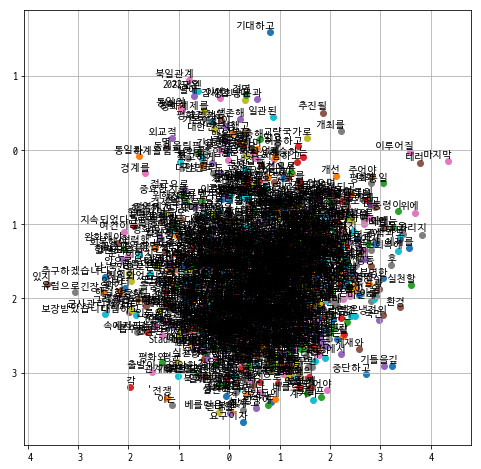

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
for i, label in enumerate(word_list):
    x, y = trained_embeddings[i]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')
plt.grid(True)
plt.show()

<br>
# **gensim | word2vec**
<br>
## **1 데이터 전처리**

In [12]:
%%time
# 텍스트를 한 줄씩 문법 tag를 추가한다
results, lines = [], texts_Berlin
from konlpy.tag import Twitter
twitter = Twitter()

for line in lines:
    malist = twitter.pos(line, norm=True, stem=True)
    result = [ word[0]   for word in malist    # 어미/조사/구두점 제외
               if not word[1] in ["Eomi", "Josa", "Punctuation"] ]
    rl = (" ".join(result)).strip()
    results.append(rl)
    
texts_file = './data/Berlin.tagged'
with open(texts_file, 'w', encoding='utf-8') as fp:
    fp.write("\n".join(results))

CPU times: user 5.74 s, sys: 182 ms, total: 5.92 s
Wall time: 2.25 s


In [13]:
! cat ./data/Berlin.tagged | head -n 5

존경 하다 독일 국민 여러분
고국 계시다 국민 여러분
하울 젠 쾨르버 재단 이사 님 모드 전 동독 총리 님 비롯 하다 내외 귀빈 여러분
먼저 냉전 분단 넘다 통일 이루다
그 힘 유럽 통합 국제 평화 선도 있다


<br>
## **2 Word 2 vec 객체 만들기**
gensim

In [14]:
%%time
from gensim.models import word2vec
data  = word2vec.LineSentence(texts_file)
model = word2vec.Word2Vec(data, size=200, window=10, hs=1, min_count=2, sg=1)
model.save("./data/Berlin.model")
print("model saved.")

model saved.
CPU times: user 320 ms, sys: 41.9 ms, total: 362 ms
Wall time: 439 ms


<br>
## **3 저장된 객체 활용**
gensim

In [15]:
from gensim.models import word2vec
model = word2vec.Word2Vec.load('./data/Berlin.model')
model.wv.most_similar(positive=['한반도'])

/home/markbaum/Python/python/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('하다', 0.9920334815979004),
 ('적', 0.9912784099578857),
 ('있다', 0.9904186725616455),
 ('째', 0.9875652194023132),
 ('수', 0.986303448677063),
 ('되다', 0.9860804677009583),
 ('것', 0.9856946468353271),
 ('정치', 0.985691249370575),
 ('이다', 0.9853699207305908),
 ('경제', 0.9851488471031189)]

In [16]:
model.wv.most_similar(positive=['통일'])

/home/markbaum/Python/python/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('하다', 0.9832950234413147),
 ('적', 0.9825476408004761),
 ('있다', 0.9817571640014648),
 ('한반도', 0.9805703163146973),
 ('이다', 0.9793375134468079),
 ('정치', 0.9792993664741516),
 ('’', 0.9783635139465332),
 ('교류', 0.9781551957130432),
 ('경제', 0.977993369102478),
 ('수', 0.9775605797767639)]

In [17]:
model.wv.most_similar(positive=['정치'])

/home/markbaum/Python/python/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('하다', 0.9904994964599609),
 ('적', 0.9882740378379822),
 ('’', 0.9858219623565674),
 ('있다', 0.9857804775238037),
 ('한반도', 0.985691249370575),
 ('교류', 0.9855000376701355),
 ('군사', 0.9853676557540894),
 ('이다', 0.9846813082695007),
 ('‘', 0.9846169352531433),
 ('경제', 0.9844136238098145)]

<br>
## **04 Visulaization**
gensim

In [18]:
# model.wv.vocab : { word: object of numeric vector }
vocab = list(model.wv.vocab)
X = model[vocab]

/home/markbaum/Python/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

In [20]:
import pandas as pd
df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])
df.head()

,x,y
존경,-14.094868,-16.335072
하다,26.034809,19.243979
독일,20.600410,15.731443
국민,-1.281013,0.759164
여러분,21.331871,14.738884


/home/markbaum/Python/python/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


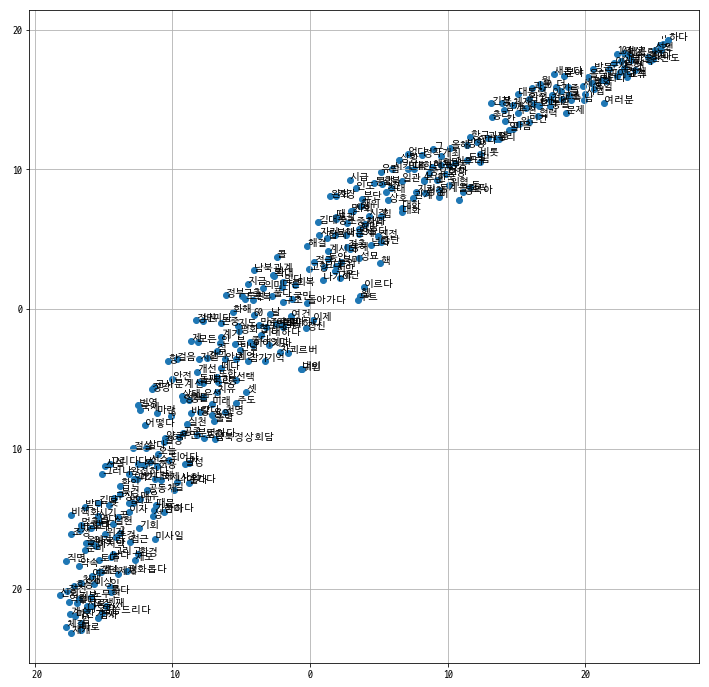

In [21]:
%matplotlib inline
from matplotlib import font_manager, rc
font_fname = './data/D2Coding.ttf'     
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family=font_name)

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,12))
plt.grid(True)
ax  = fig.add_subplot(1, 1, 1)
ax.scatter(df['x'], df['y'])
for word, pos in df.iterrows():
    ax.annotate(word, pos)

<br>
# **gensim | doc2vec**
<br>
## **1 네이버 단어 전처리**
네이버 영화리뷰 단어모델 만들기

In [22]:
from konlpy.tag import Twitter
twitter = Twitter()

def read_data(filename):
    with open(filename, 'r') as f:
        data = [line.split('\t') for line in f.read().splitlines()]
    from random import randint
    random_data = [data[randint(1, len(data))]  for no in range(int(len(data)/10)) ]
    return random_data

def tokenize(doc):
  # norm, stem은 optional
  return ['/'.join(t) for t in twitter.pos(doc, norm=True, stem=True)]

In [23]:
from collections import namedtuple
train_data        = read_data('data/ratings_train.txt')
train_docs        = [(tokenize(row[1]), row[2]) for row in train_data[1:]]
TaggedDocument    = namedtuple('TaggedDocument', 'words tags')
tagged_train_docs = [TaggedDocument(d, [c]) for d, c in train_docs]

In [24]:
from pprint import pprint
pprint(tagged_train_docs[0])

TaggedDocument(words=['아이언맨/Noun', '의/Josa', '자아/Noun', '찾기/Noun', '.../Punctuation', '3/Number', '편/Noun', '은/Josa', '그렇다/Adjective', '아이언맨/Noun', '이나/Josa', '배트맨/Noun', '이나/Josa', '스파이더맨/Noun', '이나/Josa'], tags=['1'])


<br>
## **2 doc2vec 파라미터 설정 및 학습**

In [26]:
%%time
from gensim.models import doc2vec
doc_vectorizer = doc2vec.Doc2Vec(vector_size=300, alpha=0.025, min_alpha=0.025, seed=1234)
doc_vectorizer.build_vocab(tagged_train_docs)

for epoch in range(10):
    doc_vectorizer.train(tagged_train_docs, 
                         total_examples = doc_vectorizer.corpus_count, 
                         epochs = doc_vectorizer.epochs)
    doc_vectorizer.alpha -= 0.002
    doc_vectorizer.min_alpha = doc_vectorizer.alpha 

# 학습이 완료된 모델의 데이터를 저장한다
doc_vectorizer.save('data/doc2vec.model')

CPU times: user 53.4 s, sys: 3.87 s, total: 57.3 s
Wall time: 26.8 s


<br>
## **3 doc2Vec 모델활용**

In [27]:
from gensim.models import doc2vec
from pprint import pprint
doc_vectorizer = doc2vec.Doc2Vec.load('data/doc2vec.model')
pprint(doc_vectorizer.wv.most_similar('공포/Noun'))

[('장르/Noun', 0.48491597175598145),
 ('플롯/Noun', 0.4487532675266266),
 ('신파/Noun', 0.4404942989349365),
 ('유쾌하/Noun', 0.4343223571777344),
 ('다큐/Noun', 0.43045881390571594),
 ('스릴러/Noun', 0.42965495586395264),
 ('공상/Noun', 0.42679348587989807),
 ('교과서/Noun', 0.4239139258861542),
 ('문제/Noun', 0.42317166924476624),
 ('b/Alpha', 0.39770030975341797)]


/home/markbaum/Python/python/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [28]:
pprint(doc_vectorizer.wv.most_similar('공포영화/Noun'))

[('전쟁영화/Noun', 0.4597283899784088),
 ('공포물/Noun', 0.443813294172287),
 ('스릴러/Noun', 0.4343397915363312),
 ('숨막히다/Adjective', 0.4114598035812378),
 ('홍콩영화/Noun', 0.3958229124546051),
 ('만화/Noun', 0.3917299509048462),
 ('호러/Noun', 0.3832235038280487),
 ('다큐/Noun', 0.38228297233581543),
 ('얘기/Noun', 0.3802279233932495),
 ('시리즈/Noun', 0.37976330518722534)]


/home/markbaum/Python/python/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [29]:
pprint(doc_vectorizer.wv.similarity('공포/Noun', 'ㅋㅋ/KoreanParticle'))

0.085719965


/home/markbaum/Python/python/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [30]:
pprint(doc_vectorizer.wv.most_similar(positive=['여자/Noun', '최악/Noun'], 
                                      negative=['남자/Noun']))

[('수작/Noun', 0.3395952880382538),
 ('생애/Noun', 0.3304585814476013),
 ('디워/Noun', 0.32071033120155334),
 ('최고/Noun', 0.3139539957046509),
 ('베스트/Noun', 0.3106744885444641),
 ('손색/Noun', 0.3064805269241333),
 ('다행/Noun', 0.3054335117340088),
 ('어설픈/Noun', 0.2900944650173187),
 ('아쉽다/Adjective', 0.2891661524772644),
 ('유일하/Noun', 0.28865864872932434)]


/home/markbaum/Python/python/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
